System is controllable!!
System dimension, states: 5 ,inputs: 5
Episode:  1 , ||H-H*||: 3.8191672560820153 , rho(A+BH): 1.8270588941268344 , gamma: 0.0
Episode:  2 , ||H-H*||: 1.329227142952141 , rho(A+BH): 0.5012483659145751 , gamma: 0.2940464913845062
Episode:  3 , ||H-H*||: 0.12018837058281653 , rho(A+BH): 0.22889007905065345 , gamma: 1.0
Episode:  4 , ||H-H*||: 0.021595645256429947 , rho(A+BH): 0.26073491233172413 , gamma: 1.0
Episode:  5 , ||H-H*||: 0.02160174056744149 , rho(A+BH): 0.2612837931862093 , gamma: 1.0
Episode:  6 , ||H-H*||: 0.021627404365931434 , rho(A+BH): 0.2612826718100187 , gamma: 1.0
Episode:  7 , ||H-H*||: 0.02163736478490367 , rho(A+BH): 0.2612906034062934 , gamma: 1.0
Episode:  8 , ||H-H*||: 0.02159318865567294 , rho(A+BH): 0.26128906398078644 , gamma: 1.0
Episode:  9 , ||H-H*||: 0.021632624456592617 , rho(A+BH): 0.2612911973848662 , gamma: 1.0
Episode:  10 , ||H-H*||: 0.021596492360063845 , rho(A+BH): 0.2612867411522672 , gamma: 1.0
Episode:  11 , ||H-H*||: 0

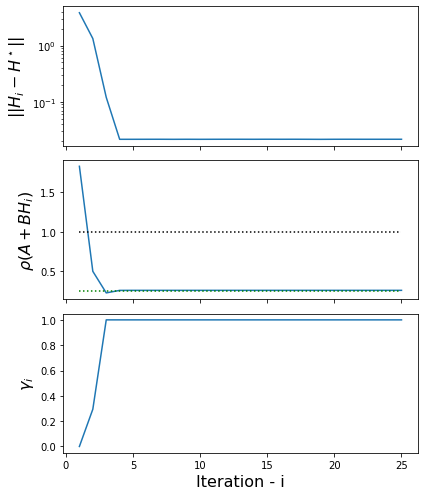

In [2]:
#import gym
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.stats as st

# Use this to generate random systems for testing
def randomSystem(n=None,p=None):    # Generate random system

    if n is None:
        n = rnd.randint(1,10)
    if p is None:
        p = rnd.randint(1,10)

    A = rnd.randn(n,n)
    B = rnd.randn(n,p)

    Q = st.wishart.rvs(n+1,np.eye(n)).reshape((n,n))
    R = st.wishart.rvs(p+1,np.eye(p)).reshape((p,p))

    Controllability = B
    for i in range(n-1):
      Controllability = np.hstack([Controllability, A@A**i @ B])
    if np.linalg.matrix_rank(Controllability) == n:
      print('System is controllable!!')
    else:
      A,B,Q,R = randomSystem(n,p)

    return A,B,Q,R


def trilStack(M):
    n = len(M)
    v = []
    for i in range(n):
        v.append(M[i:,i])
    return np.hstack(v)

def trilUnstack(v):
    d = len(v)
    n = int((np.sqrt(1+8*d)-1)/2)
    M = np.zeros((n,n))
    j = 0
    for i in range(n):
        M[i:,i] = v[j:j+n-i]
        j = j+n-i
    return M

def symFromTrilStack(v):
    L = trilUnstack(v)
    D = np.diag(np.diag(L))
    return L + L.T - D

def quadraticMonomials(z):
    M = np.outer(z,z)
    M_L = np.tril(M,-1)
    M_D = np.diag(np.diag(M))
    return trilStack(2*M_L + M_D)

def buildPhi(X,U,X_next,H,gamma):
    Horizon = len(U)
    Phi = []
    for x,u,x_next in zip(X,U,X_next):
        z = np.hstack([x,u])
        z_next = np.hstack([x_next,H@x_next])
        # Accounting for noise requires extra parameter
        psi = np.hstack(quadraticMonomials(z))
        psi_next = np.hstack(quadraticMonomials(z_next))
        phi = psi - gamma * psi_next
        Phi.append(phi)
    return np.array(Phi)
    
def buildomega2(H):
    p,n = H.shape
    a = np.vstack([np.eye(n),H])
    A = a@a.T
    A_L = np.tril(A,-1)
    A_D = np.diag(np.diag(A))
    return trilStack(2*A_L + A_D)

    
def getVandQmatrices(X,U,X_next,c,H,gamma,w):
    F = np.vstack([np.eye(n),H])
    Phi = buildPhi(X,U,X_next,H,gamma)
    omega2 = buildomega2(H)
    m = omega2.shape[0]
    omega2.shape = (1,m)
    PHI = np.hstack([Phi - gamma*w*w*np.repeat(omega2,Phi.shape[0],axis=0), (1-gamma)*np.ones((Phi[:,0].shape[0],1))])
    theta = la.lstsq(PHI,c)[0]
    # The first entry of theta is the noise variance
    Q_mat = symFromTrilStack(theta[:-1])
    C_q = theta[-1]
    P = F.T @ Q_mat @ F
    return P,Q_mat    

    
def increaseGamma(X,U,X_next,c,H,gamma,w,changeBound=1):
    #gamma = np.min([gamma+0.01,1])
    #P_new,Q_mat = getVandQmatrices(X,U,X_next,c,H,gamma)
    #return gamma, Q_mat
    
    LB = gamma 
    UB = 1.
    
    p,n = H.shape
    
    # Get the current P value
    P_cur,Q_mat = getVandQmatrices(X,U,X_next,c,H,gamma,w)
        
    # Try 1 first
    gamma = 1.
    P_new,Q_mat = getVandQmatrices(X,U,X_next,c,H,gamma,w)
    
    P_change = la.norm(P_new-P_cur)
    minEig = la.eigvalsh(P_new,eigvals=[0,0])[0]
    
    if minEig > 0:
        # gamma = 1 worked
        return gamma, Q_mat
    
    # loop_num = 0
    while ((UB-LB) > 1e-6) or (minEig < 0) or (P_change > changeBound):
        
        P_new,Q_mat = getVandQmatrices(X,U,X_next,c,H,gamma,w)
        minEig = la.eigvalsh(P_new,eigvals=[0,0])[0]
        #print('gamma',gamma)
        
        P_change = la.norm(P_cur-P_new)
  
        if (minEig < 0) or (P_change > changeBound):
            UB = gamma
        else:
            LB = gamma
            
        gamma = .5 * (LB+UB)

        if ((UB-LB) < 1e-6) and (minEig < 0):# and (P_change < changeBound):   #
          LB = 0.95*gamma
          print('Cannot find suitable Q matrix, gamma is reduced!')

        #loop_num += 1
        #if loop_num >1000:
          #print('dead loop!',((UB-LB) > 1e-6) , (minEig < 0) , (P_change > changeBound))
          #break
        
    return gamma, Q_mat

def extractGain(Q_mat,n):
    Omega = Q_mat[n:,n:]
    Psi = Q_mat[n:,:n]
    H = -la.solve(Omega,Psi)
    return H
    
def genX(n,b):
    r = rnd.rand() * b
    x = rnd.randn(n)
    return r * x / la.norm(x)

#### Main Code ##### 

A,B,Q,R = randomSystem(5,5)
n,p = B.shape
print('System dimension, states:',n,',inputs:',p)
#print('A:\n',A)
#print('B:\n',B)
#print('\n\n')

NumEpisodes = 10
x_bound = 1e12 #max(1e8, 10**(n+p-2)) #1e9 * 10**(min(0, n+p-12))
x = genX(n,x_bound)

Horizon = (p+n+1)*(p+n+2)
H = np.zeros((p,n))
gamma = 0.
w = 1      # Noise Amplitude

P_opt = la.solve_discrete_are(A,B,Q,R)
H_opt = -la.solve(R+B.T@P_opt@B,B.T@P_opt@A)

H_err = 10

ep = 0

X = []
U = []
X_next = []
c = []
# Simulate the system
for t in range(Horizon):
    u = H@x + 1e7 * w * rnd.randn(p)
    x_next = A@x + B @ u + w * rnd.randn(n)
    c.append(x@Q@x + u@R@u)
    X.append(x)
    U.append(u)
    X_next.append(x_next)
    if la.norm(x_next) <= x_bound:
        x = x_next
    else:
        x = genX(n,x_bound)
        
c = np.array(c)

ErrList = []
GammaList = []
RhoList = []

H_diff = 1
while H_diff>1e-6:    #H_err > 0.1**(10-n-p) :   #eigMax>1: #
    ep += 1
 
    
    eigMax = np.max(np.abs(la.eigvals(A+B@H)))
    H_err = la.norm(H-H_opt)
    ErrList.append(H_err)
    if ep>=2:
      H_diff = la.norm(ErrList[-1]-ErrList[-2])
    GammaList.append(gamma)
    RhoList.append(eigMax)
    print('Episode: ',ep,', ||H-H*||:',H_err, ', rho(A+BH):', eigMax,', gamma:', gamma)
    gamma,Q_mat = increaseGamma(X,U,X_next,c,H,gamma,w,changeBound=1e3)
    # improve H
    H = extractGain(Q_mat,n)


# Plot
Time = np.arange(1,len(RhoList)+1)
fig,ax = plt.subplots(3,1,figsize=(6,7),sharex=True)
ax[0].semilogy(Time,ErrList)
ax[0].set_ylabel(r'$||H_i - H^\star||$',fontsize=16)
ax[1].plot(Time,RhoList)
ax[1].plot(Time,np.ones_like(Time),'k:')
ax[1].plot(Time,np.max(np.abs(la.eigvals(A+B@H_opt)))*np.ones_like(Time),'g:')
ax[1].set_ylabel(r'$\rho(A+BH_i)$',fontsize=16)
ax[2].plot(Time,GammaList)
ax[2].set_ylabel(r'$\gamma_i$',fontsize=16)
ax[2].set_xlabel('Iteration - i',fontsize=16)
fig.tight_layout()
plt.savefig('AlgPerformance.pdf',bbox_inches='tight',transparent=True)